In [1]:
import platform, sys, os


# Variables

In [2]:
## Seed for the random variables
seed_number=0;

BATCH_SIZE=32

## Model of network
model_type = 'efficientnet_b3'
#model_type = 'mobilenet_v3';
#model_type = 'inception_v3';
#model_type = 'inception_resnet_v2';
#model_type = 'resnet_v2_50';

#DATASET_NAME = 'fer2013';
DATASET_NAME = 'mcfer_v1.0';

times=1;


# Endereços

In [3]:
## Dataset 
if platform.system()=='Linux':
    if os.getenv("COLAB_RELEASE_TAG"):
        dataset_base_dir_raw    = './';
    elif 'microsoft-standard' in platform.uname().release:
        dataset_base_dir_raw    = '/mnt/c/Dados/Fernando/DATASET';
    else:
        dataset_base_dir_raw    = '/mnt/boveda/DATASETs/FACE-EMOTION';
else:
    dataset_base_dir_raw    = 'C:\\Dados\\Fernando\\DATASET';

if DATASET_NAME=='fer2013':
    RELATIVE_DIR=os.path.join(DATASET_NAME,'archive','test');
elif DATASET_NAME=='affectnet':
    RELATIVE_DIR=os.path.join('AffectNet-Sample','input','affectnetsample','test_class');
elif DATASET_NAME=='mcfer_v1.0':
    #RELATIVE_DIR=os.path.join(DATASET_NAME,'archive','test');
    RELATIVE_DIR=os.path.join(DATASET_NAME,'archive','train');
else:
    print('Error in the dataset name:',DATASET_NAME);
    exit();

dataset_base_dir = os.path.join(dataset_base_dir_raw,RELATIVE_DIR);
print('dataset_base_dir:',dataset_base_dir)

## Output
if platform.system()=='Linux':
    if os.getenv("COLAB_RELEASE_TAG"):
        output_base_dir = 'OUTPUTS/cnn_face_emotion_'+DATASET_NAME+'/test_holdout';
    elif 'microsoft-standard' in platform.uname().release:
        output_base_dir = '/mnt/c/Dados/Fernando/OUTPUTS/cnn_face_emotion_'+DATASET_NAME+'/test_holdout';
    else:
        output_base_dir = '/mnt/boveda/DOCTORADO2/cnn_face_emotion_'+DATASET_NAME+'/test_holdout';
else:
    output_base_dir = 'C:\\Dados\\Fernando\\OUTPUTS\\cnn_face_emotion_'+DATASET_NAME+'\\test_holdout';

print('output_base_dir:',output_base_dir)


# Best model
if platform.system()=='Linux':
    if os.getenv("COLAB_RELEASE_TAG"):
        path_of_best_model_file = 'cnn_face_emotion/library/models';
    elif 'microsoft-standard' in platform.uname().release:
        path_of_best_model_file = '/mnt/c/Dados/Fernando/CODE/PESQUISA/programs-tese/cnn_face_emotion/library/models';
    else:
        path_of_best_model_file='/home/fernando/Downloads/TESIS-DOUTORADO-2/PESQUISA/programs-tese/cnn_face_emotion/library/models';
else:
    path_of_best_model_file='C:\\Dados\\Fernando\\CODE\\PESQUISA\\programs-tese\\cnn_face_emotion\\library\\models';

print('path_of_best_model_file:',path_of_best_model_file)

dataset_base_dir: /mnt/boveda/DATASETs/FACE-EMOTION/mcfer_v1.0/archive/train
output_base_dir: /mnt/boveda/DOCTORADO2/cnn_face_emotion_mcfer_v1.0/test_holdout
path_of_best_model_file: /home/fernando/Downloads/TESIS-DOUTORADO-2/PESQUISA/programs-tese/cnn_face_emotion/library/models


# Bibliotecas externas

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Biblioteca local

In [5]:
sys.path.append('library');

# If command line

In [6]:
#print('cmd entry:', sys.argv)

for n in range(len(sys.argv)):
    if sys.argv[n]=='--model':
        model_type=sys.argv[n+1];
    if sys.argv[n]=='--times':
        times=int(sys.argv[n+1]);


best_model_file=os.path.join(path_of_best_model_file,'model_'+model_type+'.h5');

print('model_type:',model_type)
print('times:',times)

model_type: efficientnet_b3
times: 1


# Set seed of random variables


In [7]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Data augmentation configuration

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg_test= ImageDataGenerator(rescale=1./255 )


# Creating output directory

In [9]:
#output_dir = os.path.join(output_base_dir,'holdout');
output_dir = os.path.join(output_base_dir,model_type);

try: 
    os.makedirs(output_dir) 
except: 
    pass


# Create new model

In [10]:
import lib_model as mpp

model, target_size = mpp.create_model('',model_type=model_type);
model.summary()

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.m'));


Loaded layer with efficientnet_b3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              10783528  
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 10,832,943
Trainable params: 10,745,647
Non-trainable params: 87,296
_________________________________________________________________


# Defining directories

In [11]:

test_data_generator  = idg_test.flow_from_directory(dataset_base_dir, 
                                                    target_size=target_size,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False
                                                    );

Found 23520 images belonging to 7 classes.


# Compile


In [12]:
# COMPILE NEW MODEL
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])


# Time

In [13]:
from pytictoc import TicToc
t = TicToc() 

# Evaluate best model

In [14]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights(best_model_file);


L=test_data_generator.samples;
print('L:',L);

print('Evaluating, please wait ...')
t.tic();
for m in range(times):
    results = model.evaluate(test_data_generator,verbose=0)
t0=t.tocvalue();
print('END. Data evaluaed')

results = dict(zip(model.metrics_names,results))
print(results,"\n\n");


with open(os.path.join(output_dir,"results_testing.m"), 'w') as f: 
    for key, value in results.items(): 
        f.write('%s=%s;\n' % (key, value));
    f.write('delayms=%s;\n' % (t0*1000.0/(times*L)));

tf.keras.backend.clear_session()


L: 23520
Evaluating, please wait ...
END. Data evaluaed
{'loss': 0.6975707411766052, 'categorical_accuracy': 0.8295493125915527} 




# Confusion Matrix

In [15]:
np.set_printoptions(threshold=np.inf)


Y_pred = model.predict(test_data_generator,verbose=1);
y_pred = np.argmax(Y_pred, axis=1)

Nelt=20;

print('\n')
print('  test_data_generator.classes[0:Nelt]:\n',test_data_generator.classes[0:Nelt])
#print('    type(test_data_generator.classes):\n',type(test_data_generator.classes))
#print('np.shape(test_data_generator.classes):\n',np.shape(test_data_generator.classes))
print('y_pred[0:Nelt,:]:\n',y_pred[0:Nelt])
#print('    type(y_pred):\n',type(y_pred))
#print('np.shape(y_pred):\n',np.shape(y_pred))


735/735 [==============================] - 2678s 4s/step


  test_data_generator.classes[0:Nelt]:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_pred[0:Nelt,:]:
 [4 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



Confussion Matrix:


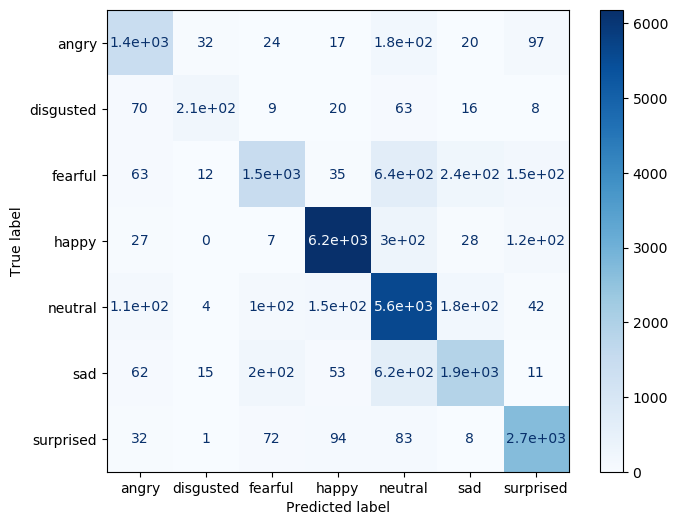


Classification Report:
              precision    recall  f1-score   support

       angry       0.80      0.80      0.80      1816
   disgusted       0.77      0.53      0.63       397
     fearful       0.78      0.57      0.66      2618
       happy       0.94      0.93      0.94      6665
     neutral       0.75      0.91      0.82      6184
         sad       0.79      0.66      0.72      2851
   surprised       0.86      0.90      0.88      2989

    accuracy                           0.83     23520
   macro avg       0.81      0.76      0.78     23520
weighted avg       0.83      0.83      0.83     23520



In [16]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = ['angry','disgusted','fearful','happy','neutral','sad','surprised'];


# Confusion matrix
print('\nConfussion Matrix:')
fname=os.path.join(output_dir,"confusion_matrix.png")
CM=confusion_matrix(test_data_generator.classes, y_pred);
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=target_names)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.savefig(fname)
plt.show()
fname=os.path.join(output_dir,"confusion_matrix.txt")
np.savetxt(fname, CM, fmt='%8.6e') 
fname=os.path.join(output_dir,"confusion_matrix.label.txt")
file = open(fname,'w')
for item in target_names:
    file.write(item+"\n")
file.close()



# Classification report
print('\nClassification Report:')
fname=os.path.join(output_dir,"classification_report.txt")
str_dat=classification_report(test_data_generator.classes, y_pred, target_names=target_names);
print(str_dat)
with open(fname, 'w') as f: 
    f.write('%s\n' % str_dat);
    f.close()
